In [1]:
import pandas as pd
import numpy as np
import datetime, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import random

In [2]:
def get_unix(latency):
    millisecond = datetime.datetime.now() - datetime.timedelta(seconds=latency)
    unixtimestamp = int(millisecond.timestamp() * 1000)
    return unixtimestamp

In [3]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

In [4]:
df = pd.read_csv("Data/data_drift_20.csv",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'latency': pd.Series(dtype='float'),
                   'drift': pd.Series(dtype='int')})

In [5]:
def calc_metric(driftTime, detectTime, threshold, false_alarm_threshold=5):
    
    tsDrift = datetime.datetime.fromtimestamp(int(driftTime)/1000)  
    tsDetect = datetime.datetime.fromtimestamp(int(detectTime)/1000)  
    diff = tsDetect - tsDrift
    diff = diff.total_seconds()
    if diff > 0 and diff <= threshold:
        return "TP"
    elif diff > 0 and diff> threshold and diff<false_alarm_threshold:
        return "FN"
    return "FP"
    

In [6]:
df.head()

,ingestion,event,latency,drift
0,1658333937152,1658333934104,3.048357,0
1,1658333937167,1658333934436,2.730868,0
2,1658333937181,1658333934057,3.123844,0
3,1658333937195,1658333933633,3.561515,0
4,1658333937210,1658333934527,2.682923,0


In [7]:
def evaluate(threshold, df_p):
    TOTAL_DRIFT= 20
    detectedTS = df_p["ingestion"].tolist()
    driftsTS = df.query("drift == 1")["ingestion"].tolist()

    result= dict()
    result["name"] =  df_p["algorithm"].unique()[0]
    result["predictedDrift"] = len(detectedTS)
    result["TP"]=0 # should be drift  and it is in threshold
    result["FN"]=0 # should be drift it is not in threshold
    result["FP"]=0 # should not be drift (false alarm)
   
    
    
    
    for index,ingestion in enumerate(driftsTS):
        total_drift = len(driftsTS)
        
        first_drift = driftsTS[index]
        if index < total_drift-1:
            second_drift = driftsTS[index+1]
        else:
            second_drift = 9999999999999
        first_accepted = False # it can be 2 predictions within a period
        for j in detectedTS:
            if j > first_drift and j < second_drift:
                metric = calc_metric(ingestion, j, threshold)
                
                if metric == "TP":
                    result["TP"] += 1
                    first_accepted = True
                else:
                    if metric == "FP":
                        result["FP"] += 1
                    elif first_accepted:
                        result["FP"] += 1
                    elif metric == "FN":
                        result["FN"] += 1
                    else:
                        print("NA")
        

    
    return result

In [25]:
import os
os.listdir("Result/parameter/")

['result_test_PageHinkley_20.csv',
 'result_test_CUSUM_60.csv',
 'result_test_PageHinkley_5.csv',
 'result_test_CUSUM_5.csv',
 'result_test_CUSUM_70.csv',
 'result_test_PageHinkley_30.csv',
 'result_test_PageHinkley_40.csv',
 'result_test_PageHinkley_50.csv',
 'result_test_CUSUM_10.csv',
 'result_test_CUSUM_20.csv',
 'result_test_PageHinkley_60.csv',
 'result_test_PageHinkley_70.csv',
 'result_test_CUSUM_30.csv',
 'result_test_CUSUM_40.csv',
 'result_test_CUSUM_50.csv',
 'result_test_PageHinkley_10.csv']

In [26]:
files = os.listdir("Result/parameter/")

In [27]:
thresholds = [0.75]
df_result = pd.DataFrame({'algorithm': pd.Series(dtype='str'),'threshold': pd.Series(dtype='int'),
                   'predictedDrift': pd.Series(dtype='int'),
                          'TP': pd.Series(dtype='int'),'FP': pd.Series(dtype='int'),
                          'FN': pd.Series(dtype='float'),
                           'Sensitivity': pd.Series(dtype='float'),
                         'Precision': pd.Series(dtype='float'),})


for f in files:
    df_processed = pd.read_csv(f"Result/parameter/{f}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
    
    
    for t in thresholds:
        result = evaluate(t, df_processed)
        try:
            precision = result["TP"]/ ( result["TP"] + result["FP"])
        except:
            precision: 0
        df_result = df_result.append({"algorithm":result["name"] ,"threshold": t, "TP": result["TP"],
                                      "FP":result["FP"],  "FN": result["FN"],
                                      "predictedDrift": result["predictedDrift"],
                                     "Sensitivity": result["TP"]/ (result["TP"] + result["FN"]),
                                     "Precision": precision, },ignore_index=True) 

In [30]:
df_result['algorithm_threshold'] = df_result['algorithm'].str.split('_').str[1]

In [32]:
df_result['algorithm'] = df_result['algorithm'].str.split('_').str[0]

In [37]:
df_result["algorithm_threshold"] = df_result["algorithm_threshold"].astype(int)

In [42]:
df_page = df_result.query("algorithm == 'PageHinkley'").sort_values(by=["algorithm_threshold"])
df_cusum = df_result.query("algorithm == 'CUSUM'").sort_values(by=["algorithm_threshold"])

In [63]:
df_2 = df_result.sort_values(by=["algorithm","algorithm_threshold"]).query("algorithm_threshold < 60")

In [72]:
df_2

,algorithm,threshold,predictedDrift,TP,FP,FN,Sensitivity,Precision,algorithm_threshold
3,CUSUM,0.75,114,9,92,4.0,0.692308,0.089109,5
8,CUSUM,0.75,35,8,23,1.0,0.888889,0.258065,10
9,CUSUM,0.75,14,9,4,1.0,0.900000,0.692308,20
12,CUSUM,0.75,12,9,2,1.0,0.900000,0.818182,30
13,CUSUM,0.75,11,8,1,2.0,0.800000,0.888889,40
14,CUSUM,0.75,11,8,1,2.0,0.800000,0.888889,50
2,PageHinkley,0.75,7,3,1,2.0,0.600000,0.750000,5
15,PageHinkley,0.75,7,2,1,2.0,0.500000,0.666667,10
0,PageHinkley,0.75,4,1,2,1.0,0.500000,0.333333,20
5,PageHinkley,0.75,4,1,2,1.0,0.500000,0.333333,30


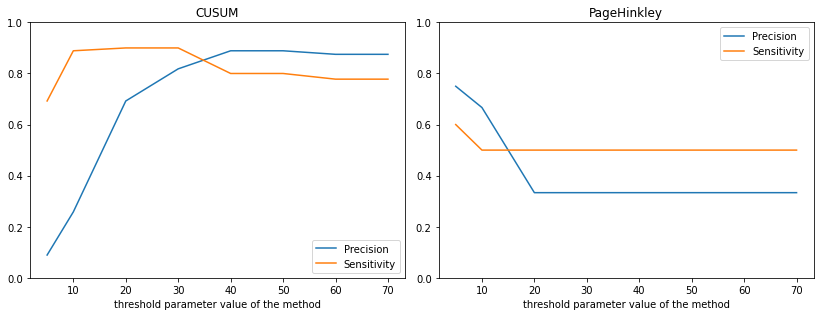

In [101]:
import matplotlib.pyplot as plt
  
plt.rcParams["figure.figsize"] = [11.50, 4.50]
plt.rcParams["figure.autolayout"] = True

# create data
thresholds = df_cusum["algorithm_threshold"].tolist()
#tp = df_cusum["TP"].tolist()
Precision = df_cusum["Precision"].tolist()
Sensitivity = df_cusum["Sensitivity"].tolist()
plt.subplot(121)
# plot lines
#plt.plot( thresholds, tp, label = "TP")
plt.plot( thresholds, Precision, label = "Precision")
plt.plot( thresholds, Sensitivity, label = "Sensitivity")
plt.title("CUSUM")
plt.xlabel("threshold parameter value of the method")
plt.legend()

  
# create data
thresholds = df_page["algorithm_threshold"].tolist()
#tp = df_cusum["TP"].tolist()
Precision = df_page["Precision"].tolist()
Sensitivity = df_page["Sensitivity"].tolist()
plt.ylim(ymax = 1, ymin = 0)
plt.subplot(122)
# plot lines
#plt.plot( thresholds, tp, label = "TP")
plt.plot( thresholds, Precision, label = "Precision")
plt.plot( thresholds, Sensitivity, label = "Sensitivity")
plt.title("PageHinkley")
plt.xlabel("threshold parameter value of the method")
plt.legend()
plt.ylim(ymax = 1, ymin = 0)
#plt.show()

plt.savefig("parameter.png")

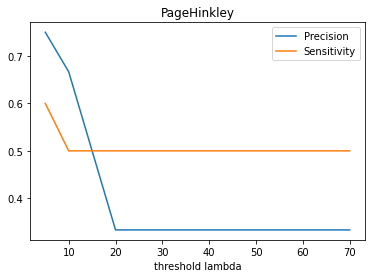

In [83]:
import matplotlib.pyplot as plt
  
# create data
thresholds = df_page["algorithm_threshold"].tolist()
#tp = df_cusum["TP"].tolist()
Precision = df_page["Precision"].tolist()
Sensitivity = df_page["Sensitivity"].tolist()
  
# plot lines
#plt.plot( thresholds, tp, label = "TP")
plt.plot( thresholds, Precision, label = "Precision")
plt.plot( thresholds, Sensitivity, label = "Sensitivity")
plt.title("PageHinkley")
plt.xlabel("threshold lambda")
plt.legend()
plt.show()

In [40]:
df_page.sort_values(by=["algorithm_threshold"])

,algorithm,threshold,predictedDrift,TP,FP,FN,Sensitivity,Precision,algorithm_threshold
2,PageHinkley,0.75,7,3,1,2.0,0.6,0.750000,5
15,PageHinkley,0.75,7,2,1,2.0,0.5,0.666667,10
0,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,20
5,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,30
6,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,40
7,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,50
10,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,60
11,PageHinkley,0.75,4,1,2,1.0,0.5,0.333333,70


In [64]:
df_2

,algorithm,threshold,predictedDrift,TP,FP,FN,Sensitivity,Precision,algorithm_threshold
3,CUSUM,0.75,114,9,92,4.0,0.692308,0.089109,5
8,CUSUM,0.75,35,8,23,1.0,0.888889,0.258065,10
9,CUSUM,0.75,14,9,4,1.0,0.900000,0.692308,20
12,CUSUM,0.75,12,9,2,1.0,0.900000,0.818182,30
13,CUSUM,0.75,11,8,1,2.0,0.800000,0.888889,40
14,CUSUM,0.75,11,8,1,2.0,0.800000,0.888889,50
2,PageHinkley,0.75,7,3,1,2.0,0.600000,0.750000,5
15,PageHinkley,0.75,7,2,1,2.0,0.500000,0.666667,10
0,PageHinkley,0.75,4,1,2,1.0,0.500000,0.333333,20
5,PageHinkley,0.75,4,1,2,1.0,0.500000,0.333333,30


In [67]:
def print_latex(data):
    data = list(data.to_dict(orient="records"))
    for i in data:
        precision= "{:.2f}".format(i["Precision"])
        sensitivity= "{:.2f}".format(i["Sensitivity"])
        missed_prediction = int(20-i["TP"]-i["FN"])
        print(f'{i["algorithm"]}  & {i["algorithm_threshold"]}  & {i["predictedDrift"]} & {i["TP"]} & {i["FP"]} & { int(i["FN"])} & {missed_prediction} & {sensitivity} & {precision}  \\\ \hline') 

In [69]:
print_latex(df_2)

CUSUM  & 5  & 114 & 9 & 92 & 4 & 7 & 0.69 & 0.09  \\ \hline
CUSUM  & 10  & 35 & 8 & 23 & 1 & 11 & 0.89 & 0.26  \\ \hline
CUSUM  & 20  & 14 & 9 & 4 & 1 & 10 & 0.90 & 0.69  \\ \hline
CUSUM  & 30  & 12 & 9 & 2 & 1 & 10 & 0.90 & 0.82  \\ \hline
CUSUM  & 40  & 11 & 8 & 1 & 2 & 10 & 0.80 & 0.89  \\ \hline
CUSUM  & 50  & 11 & 8 & 1 & 2 & 10 & 0.80 & 0.89  \\ \hline
PageHinkley  & 5  & 7 & 3 & 1 & 2 & 15 & 0.60 & 0.75  \\ \hline
PageHinkley  & 10  & 7 & 2 & 1 & 2 & 16 & 0.50 & 0.67  \\ \hline
PageHinkley  & 20  & 4 & 1 & 2 & 1 & 18 & 0.50 & 0.33  \\ \hline
PageHinkley  & 30  & 4 & 1 & 2 & 1 & 18 & 0.50 & 0.33  \\ \hline
PageHinkley  & 40  & 4 & 1 & 2 & 1 & 18 & 0.50 & 0.33  \\ \hline
PageHinkley  & 50  & 4 & 1 & 2 & 1 & 18 & 0.50 & 0.33  \\ \hline


In [64]:
def plot_drifts(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"Result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        algorithm = df_processed["algorithm"].unique()[0]
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_title(algorithm)
        ax1.plot(df["latency"], label='Stream')

        driftsExtra = df_processed["indexNumber"].tolist()
        """
        drifts= list(df.query("drift == 1").index)
        if len(drifts) > 0:
            for i in drifts:
                ax1.axvline(i, color='red')
        """
        for i in driftsExtra:
            ax1.axvline(i, color='orange')
    #plt.xlim([800, 1200])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

In [65]:
def plot_data(df, driftsExtra=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1 = plt.subplot(gs[0])
    ax1.grid()
    ax1.plot(df["latency"], label='Stream')
    drifts= list(df.query("drift == 1").index)
    if len(drifts) > 0:
        for i in drifts:
            ax1.axvline(i, color='red')
    if driftsExtra:
        for i in driftsExtra:
            ax1.axvline(i, color='yellow')
    
    plt.show()

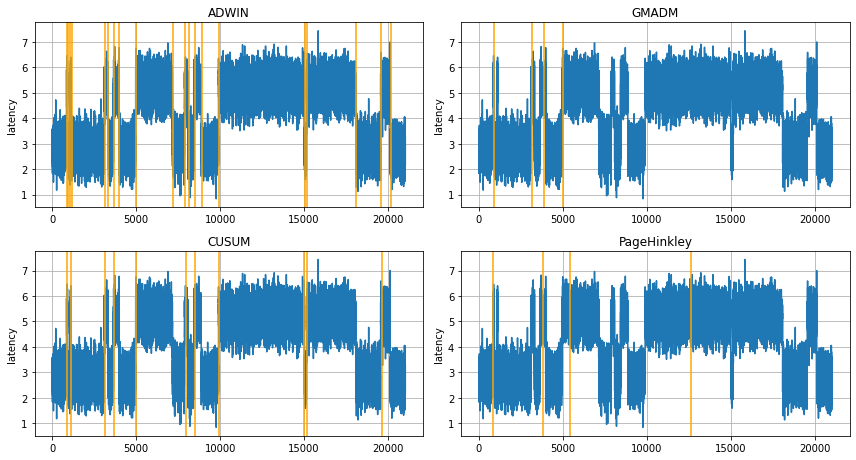

In [66]:
plot_drifts(df,files, "drift_result_plots.png")

In [46]:
def plot_drifts_ex(df,  files , save_fig=None):
    fig = plt.figure(figsize=(12,6.5), tight_layout=True)
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 3])
    
    for index, file in enumerate(files):
        df_processed = pd.read_csv(f"conceptdrift/Data/result/{file}",names={'ingestion': pd.Series(dtype='int'),'event': pd.Series(dtype='int'),
                   'indexNumber': pd.Series(dtype='int'),
                   'algorithm': pd.Series(dtype='str')})
        ax1 = plt.subplot(gs[index])
        ax1.grid()
        ax1.set_ylabel('latency')
        ax1.set_xlabel('ingestion unix timestamp')
        ax1.plot(df["ingestion"],df["latency"], label='Stream')

        driftsExtra = df_processed["ingestion"].tolist()
        
        drifts= df.query("drift == 1")
        if drifts.shape[0] > 0:
            for index, row in drifts.iterrows():
                ax1.axvline(int(row["ingestion"]), color='red')
       
        for i in driftsExtra:
            ax1.axvline(int(i), color='orange')
        
    plt.xlim([1658333948701, 1658333951107])
    
    #plt.ylim([0, 7])
    red_patch = mpatches.Patch(color='red', label='actual drift')
    orange_patch = mpatches.Patch(color='orange', label='predicted drift')
    plt.legend(handles=[red_patch,orange_patch])
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

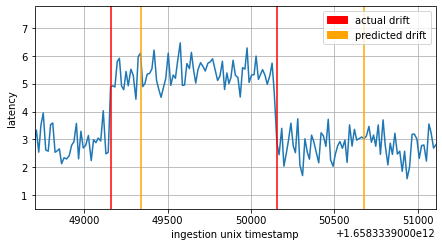

In [47]:
plot_drifts_ex(df,["result_sudden_ADWIN.csv"])